# MACHINE LEARNING PROJECT
## Abdirisaq Farah, Nguyen Hoang - BS19BDS012
### Instructor: Professor Aditya Narvekar 

Assuming we are a young start-up group whose business model focuses on retailing and sales. For the first one year the revenue is going up unremarkably and we do not make any profits yet. However, from the beginning of the second year, after a succesful marketing campaign that boosts our sales and reputation, we've acquired more and more customers day by day. 
We eventually decided to scale up our business by collecting data of customers and evaluating each of them by calculating their lifetime value - one of the five most important features of the retail industry.
At the end of this notebook, we apply some necessary algorithms with a purpose of checking correlations between varirables in the dataset, measuring accuracy, and making some predictions for better campaigns in the future.

This notebook consists of 4 main parts: insights understanding, data visualization, rfm calculation & customer segmentations, and machine learning applications.

In [1]:
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df = pd.read_csv('Transaction.csv', parse_dates=['trans_date'])

In [3]:
df

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
...,...,...,...
124995,CS8433,2011-06-26,64
124996,CS7232,2014-08-19,38
124997,CS8731,2014-11-28,42
124998,CS8133,2013-12-14,13


In [4]:
df.to_csv("Transactions.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


### CHECK THE LATEST AND EARLIEST DATE OF TRANSACTION

In [6]:
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


### THE DATE OF THIS STUDY IS THE FIRST DAY OF 2016
we're gonna check how many days since the last date a customer made a purchase, the date of this study - the transaction date

In [7]:
ai = dt.datetime(2016, 1, 1)

In [8]:
#take the history of transaction 
#add column to your dataset 
df['history'] = ai - df['trans_date']
df['history'].astype('timedelta64[D]')
df['history'] = df['history'] / np.timedelta64(1, 'D')
df.head()

,customer_id,trans_date,tran_amount,history
0,CS5295,2013-02-11,35,1054.0
1,CS4768,2015-03-15,39,292.0
2,CS2122,2013-02-26,52,1039.0
3,CS1217,2011-11-16,99,1507.0
4,CS1850,2013-11-20,78,772.0


### ASSUMING WE'RE CONSIDERING CUSTOMERS IN 1 YEAR BACK FROM NOW

In [9]:
#create a new dataset for one year customers
df = df[df['history'] < 730]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38795 entries, 1 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  38795 non-null  object        
 1   trans_date   38795 non-null  datetime64[ns]
 2   tran_amount  38795 non-null  int64         
 3   history      38795 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [10]:
#groupby customer id to calculate rfm point for each 
rfmTable = df.groupby('customer_id').agg({'history':lambda x:x.min(),
                                         'customer_id': lambda x: len(x),
                                         'tran_amount': lambda x: x.sum()})
#rfm is a new table that satisfy the conditions for each factors: 
#recency takes up new customers, frequency takes up the number of transactions, monetary_value for each order then sum up

#rename all the factors for better understanding
rfmTable.rename(columns = {'history': 'recency',
                          'customer_id': 'frequency',
                          'tran_amount' : 'monetary_value'},  inplace = True)

In [11]:
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
CS1112,352.0,4,251
CS1113,326.0,7,446
CS1114,323.0,7,504
CS1115,302.0,5,368
CS1116,494.0,5,333


In [12]:
df[df['customer_id'] == 'CS1112']

,customer_id,trans_date,tran_amount,history
5650,CS1112,2015-01-14,39,352.0
17810,CS1112,2014-07-16,90,534.0
26626,CS1112,2014-04-29,63,612.0
31500,CS1112,2014-12-04,59,393.0



RFM analysis involves categorising R,F and M into 3 or more categories. For convenience, let's create 4 categories based on quartiles (quartiles roughly divide the sample into 4 segments equal proportion). 

In [13]:
quartiles = rfmTable.quantile(q = [0.25,0.50,0.75])
print (quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25    312.0        4.0          216.75
0.50    344.0        5.0          351.00
0.75    401.0        7.0          498.00 <class 'pandas.core.frame.DataFrame'>


In [14]:
#CONVERTING THE QUARTILE INFO INTO A DICTIONARY SO CUTOFFS CAN BE PICKED UP

In [15]:
quartiles = quartiles.to_dict()
quartiles 

{'recency': {0.25: 312.0, 0.5: 344.0, 0.75: 401.0},
 'frequency': {0.25: 4.0, 0.5: 5.0, 0.75: 7.0},
 'monetary_value': {0.25: 216.75, 0.5: 351.0, 0.75: 498.0}}

### STANDARDIZE CRITERIA FOR OUR 3 FACTORS

In [16]:
# for Recency 
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1 
    elif x <= d[p][0.50]:
        return 2 
    elif x <= d[p][0.75]:
        return 3 
    else:
        return 4 
    
# for Frequency and Monetary Value 

def FMClass(x,p,d):
    if x <= d[p][0.25]: 
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else: 
        return 1 

In [17]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args =('recency', quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args =('frequency', quartiles))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args =('monetary_value', quartiles,))
rfmSeg

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
customer_id,,,,,,
CS1112,352.0,4,251,3,4,3
CS1113,326.0,7,446,2,2,2
CS1114,323.0,7,504,2,2,1
CS1115,302.0,5,368,1,3,2
CS1116,494.0,5,333,4,3,3
...,...,...,...,...,...,...
CS8996,388.0,6,336,3,2,3
CS8997,552.0,2,84,4,4,4
CS8998,375.0,4,130,3,4,4


In [18]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [19]:
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS1112,352.0,4,251,3,4,3,343
CS1113,326.0,7,446,2,2,2,222
CS1114,323.0,7,504,2,2,1,221
CS1115,302.0,5,368,1,3,2,132
CS1116,494.0,5,333,4,3,3,433


In [20]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending = [True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS5244,307.0,17,1162,1,1,1,111
CS2647,294.0,14,1158,1,1,1,111
CS3270,294.0,16,1145,1,1,1,111
CS2945,299.0,14,1069,1,1,1,111
CS2331,300.0,14,1053,1,1,1,111
...,...,...,...,...,...,...,...
CS8261,665.0,1,14,4,4,4,444
CS7288,542.0,1,12,4,4,4,444
CS7956,562.0,1,12,4,4,4,444


In [21]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111    669.339114
112    449.057692
113    316.000000
121    538.801724
122    433.466238
123    290.890110
124    187.692308
132    388.666667
133    296.500000
134    178.529412
142    366.000000
143    270.426752
144    139.353591
211    655.985782
212    440.520833
213    309.538462
221    541.269841
222    430.354839
223    289.650943
224    197.363636
232    391.892157
233    295.280576
234    181.857143
242    366.166667
243    272.872611
244    145.539062
311    654.242105
312    449.410256
313    323.200000
321    537.344086
322    431.149007
323    296.836364
324    179.750000
332    388.657407
333    299.705479
334    176.277778
342    354.000000
343    269.289216
344    139.677778
411    631.215054
412    468.250000
413    319.333333
421    535.230769
422    431.056604
423    289.585366
424    184.250000
432    385.284404
433    301.007634
434    181.444444
442    366.333333
443    266.908745
444    124.086253
Name: monetary_value, dtype: float64

In [22]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] + rfmSeg['M_Quartile']
print (rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6844 entries, CS1112 to CS9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6844 non-null   float64
 1   frequency       6844 non-null   int64  
 2   monetary_value  6844 non-null   int64  
 3   R_Quartile      6844 non-null   int64  
 4   F_Quartile      6844 non-null   int64  
 5   M_Quartile      6844 non-null   int64  
 6   RFMClass        6844 non-null   object 
 7   Total Score     6844 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 481.2+ KB
             recency  frequency  monetary_value  R_Quartile  F_Quartile  \
customer_id                                                               
CS1112         352.0          4             251           3           4   
CS1113         326.0          7             446           2           2   
CS1114         323.0          7             504           2           2   
CS1

### Assign values to our targeted customers 

In [23]:
rfmSeg

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
customer_id,,,,,,,,
CS1112,352.0,4,251,3,4,3,343,10
CS1113,326.0,7,446,2,2,2,222,6
CS1114,323.0,7,504,2,2,1,221,5
CS1115,302.0,5,368,1,3,2,132,6
CS1116,494.0,5,333,4,3,3,433,10
...,...,...,...,...,...,...,...,...
CS8996,388.0,6,336,3,2,3,323,8
CS8997,552.0,2,84,4,4,4,444,12
CS8998,375.0,4,130,3,4,4,344,11


In [24]:
len(rfmSeg) 

6844

In [25]:
rfmSeg.iloc[0,2] 

251

In [26]:
rfmSeg['F&M'] = (rfmSeg['F_Quartile'] + rfmSeg['M_Quartile']) / 2

In [27]:
#rfmSeg['Segmentation'] = ''
#for i in range (len(rfmSeg)):
    #if rfmSeg.iloc[i,3] == rfmSeg.iloc[i,4] == 4 or rfmSeg.iloc[i,3] == rfmSeg.iloc[i,4] == 5: 
        #rfmSeg['Segmentation'][i] = 'Champions'
    #elif rfmSeg.iloc[i,]

In [28]:
rfmSeg

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,F&M
customer_id,,,,,,,,,
CS1112,352.0,4,251,3,4,3,343,10,3.5
CS1113,326.0,7,446,2,2,2,222,6,2.0
CS1114,323.0,7,504,2,2,1,221,5,1.5
CS1115,302.0,5,368,1,3,2,132,6,2.5
CS1116,494.0,5,333,4,3,3,433,10,3.0
...,...,...,...,...,...,...,...,...,...
CS8996,388.0,6,336,3,2,3,323,8,2.5
CS8997,552.0,2,84,4,4,4,444,12,4.0
CS8998,375.0,4,130,3,4,4,344,11,4.0


In [29]:
#This segmentation is based on 
rfmSeg['Segmentation'] = ''
for i in range (len(rfmSeg)):
    if 4 <= rfmSeg.iloc[i,3] <= 5 and 4 <= rfmSeg.iloc[i,8] <= 5:
        rfmSeg['Segmentation'][i] = 'Champions'
    elif 2 <= rfmSeg.iloc[i,3] <= 5 and 3 <= rfmSeg.iloc[i,8] <= 5: 
        rfmSeg['Segmentation'][i] = 'Loyal Customers'
    elif 3 <= rfmSeg.iloc[i,3] <= 5 and 1 <= rfmSeg.iloc[i,8] <= 3: 
        rfmSeg['Segmentation'][i] = "Potential Loyalist"
    elif 4<= rfmSeg.iloc[i,3] <= 5 and 0<= rfmSeg.iloc[i,8] <= 1:
        rfmSeg['Segmentation'][i] = "Recent Customers"
    elif 3<= rfmSeg.iloc[i,3] <= 4 and 0 <= rfmSeg.iloc[i,8] <= 1: 
        rfmSeg['Segmentation'][i] = "Promising"
    elif 2<= rfmSeg.iloc[i,3] <= 3 and 2 <= rfmSeg.iloc[i,8] <= 3: 
        rfmSeg['Segmentation'][i] = "Customers Needing Attention"
    elif 2 <= rfmSeg.iloc[i,3] <= 3 and 0 <= rfmSeg.iloc[i,8] <= 2: 
        rfmSeg['Segmentation'][i] = "About To Sleep"
    elif 0 <= rfmSeg.iloc[i,3] <= 2 and 2 <= rfmSeg.iloc[i,8] <= 5: 
        rfmSeg['Segmentation'][i] = "At Risk"
    elif 0<= rfmSeg.iloc[i,3] <= 1 and 4 <= rfmSeg.iloc[i,8] <= 5: 
        rfmSeg['Segmentation'][i] = "Can't lose them"
    elif 1 <= rfmSeg.iloc[i,3] <= 2 and 1 <= rfmSeg.iloc[i,8] <= 2: 
        rfmSeg['Segmentation'][i] = "Hibernating"
    elif 0 <= rfmSeg.iloc[i,3] <= 2 and 0 <= rfmSeg.iloc[i,8] <= 2: 
        rfmSeg['Segmentation'][i] = "Lost"
print(rfmSeg)

C:\Users\nhoan\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\nhoan\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\nhoan\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nhoan\anaconda3\lib\site-packages\ipyk

             recency  frequency  monetary_value  R_Quartile  F_Quartile  \
customer_id                                                               
CS1112         352.0          4             251           3           4   
CS1113         326.0          7             446           2           2   
CS1114         323.0          7             504           2           2   
CS1115         302.0          5             368           1           3   
CS1116         494.0          5             333           4           3   
...              ...        ...             ...         ...         ...   
CS8996         388.0          6             336           3           2   
CS8997         552.0          2              84           4           4   
CS8998         375.0          4             130           3           4   
CS8999         548.0          2              42           4           4   
CS9000         307.0          5             131           1           3   

             M_Quartile 

In [30]:
rfmSeg 

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,F&M,Segmentation
customer_id,,,,,,,,,,
CS1112,352.0,4,251,3,4,3,343,10,3.5,Loyal Customers
CS1113,326.0,7,446,2,2,2,222,6,2.0,Customers Needing Attention
CS1114,323.0,7,504,2,2,1,221,5,1.5,About To Sleep
CS1115,302.0,5,368,1,3,2,132,6,2.5,At Risk
CS1116,494.0,5,333,4,3,3,433,10,3.0,Loyal Customers
...,...,...,...,...,...,...,...,...,...,...
CS8996,388.0,6,336,3,2,3,323,8,2.5,Potential Loyalist
CS8997,552.0,2,84,4,4,4,444,12,4.0,Champions
CS8998,375.0,4,130,3,4,4,344,11,4.0,Loyal Customers


# Data Visualization

In [31]:
cnt = 0 
visited = []

for i in range (0, len(rfmSeg['Segmentation'])):
    if rfmSeg['Segmentation'][i] not in visited:
        visited.append(rfmSeg['Segmentation'][i])
        cnt += 1
print ("no of. Unique values:", cnt)
print ("Unique values are:", visited)

seg = list(rfmSeg['Segmentation'].value_counts())

total = []
for u in range (len(seg)):
    total.append(seg[u]/len(rfmSeg)*100)
total


no of. Unique values: 7
Unique values are: ['Loyal Customers', 'Customers Needing Attention', 'About To Sleep', 'At Risk', 'Potential Loyalist', 'Hibernating', 'Champions']


[26.227352425482174,
 21.405610753945062,
 15.020455873758037,
 10.841613091759205,
 10.037989479836353,
 8.708357685563998,
 7.758620689655173]

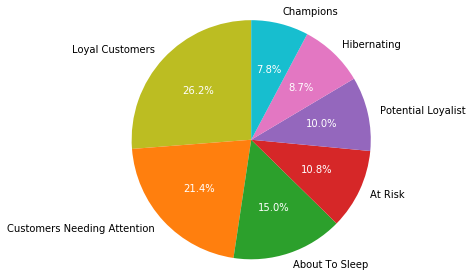

In [32]:
#draw a piechart
fig1, ax1 = plt.subplots()
colors = ['#bcbd22', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#e377c2', '#17becf']
patches, texts, autotexts = ax1.pie(total, colors = colors, labels = visited, autopct = '%1.1f%%', startangle = 90)

for text in texts:
    text.set_color('black')
    
for autotext in autotexts:
    autotext.set_color('white')
    
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [33]:
feature = ['recency', 'frequency', 'monetary_value']

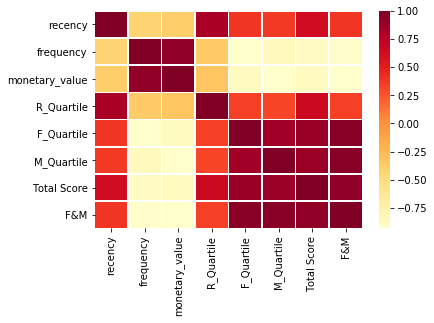

In [34]:
hm = sns.heatmap(rfmSeg.corr(), linewidths = 0.5, cmap="YlOrRd")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

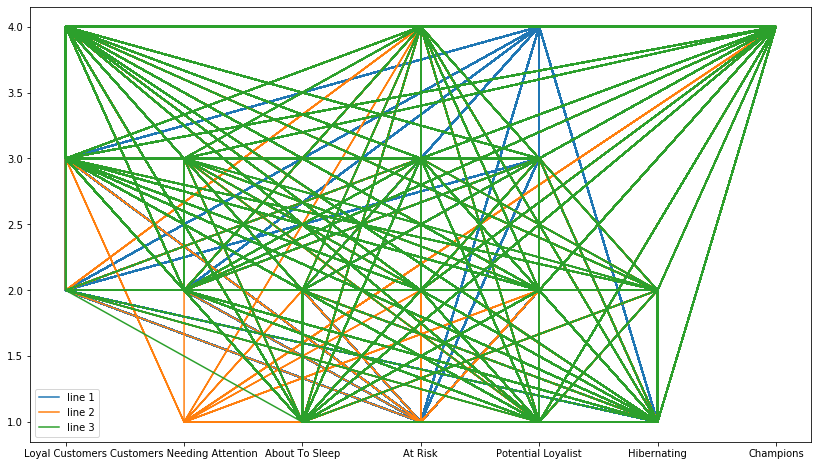

In [68]:
plt.figure(figsize=(14, 8))
plt.plot(rfmSeg['Segmentation'], rfmSeg['R_Quartile'], label = "line 1")
plt.plot(rfmSeg['Segmentation'], rfmSeg['F_Quartile'], label = "line 2")
plt.plot(rfmSeg['Segmentation'], rfmSeg['M_Quartile'], label = "line 3")
plt.legend()
plt.show()

# Linear Regression

In [36]:
feature = ['recency', 'frequency', 'monetary_value']
X = rfmSeg[feature]

In [37]:
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(6844, 3)


In [38]:
y = rfmSeg['Total Score']
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(6844,)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [40]:
print(X_train.shape)
print(y_train.shape)

(5475, 3)
(5475,)


In [41]:
print(X_test.shape)
print(y_test.shape)

(1369, 3)
(1369,)


In [42]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [43]:
linear = LinearRegression()

In [44]:
linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
print(linear.coef_)
print(linear.intercept_)

[ 0.01222342 -0.40076838 -0.00589216]
7.559435244435861


In [46]:
y_predict = linear.predict(X_test)

In [47]:
y_predict

array([ 4.88556967,  6.0665133 , 13.71305439, ...,  8.34584937,
        8.60554371,  2.71117024])

In [48]:
y_predict.shape

(1369,)

In [49]:
a = np.array(y_test)

In [50]:
a

array([ 4,  5, 12, ...,  9, 10,  3], dtype=int64)

In [51]:
print(linear.score(X_test, y_test)*100)

87.17035050546565


In [52]:
%matplotlib inline
import seaborn as sns

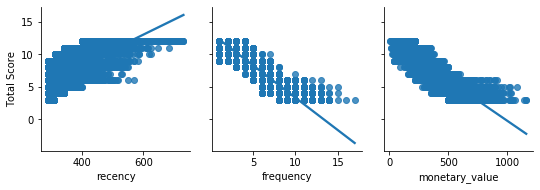

In [53]:
sns.pairplot(rfmSeg, x_vars = ['recency', 'frequency', 'monetary_value'], y_vars = 'Total Score', kind = 'reg')

## Statistics References

In [54]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Score   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 1.636e+04
Date:                Tue, 18 May 2021   Prob (F-statistic):               0.00
Time:                        13:33:52   Log-Likelihood:                -9530.1
No. Observations:                6844   AIC:                         1.907e+04
Df Residuals:                    6840   BIC:                         1.910e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.5422      0.081     92.

# Decision Tree 

In [55]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [56]:
regr_1 = DecisionTreeRegressor(max_depth=20)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_4 = DecisionTreeRegressor(max_depth=50)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [57]:
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)


In [58]:
y_2

array([ 4.        ,  4.85674931, 12.        , ...,  9.        ,
       10.17088608,  3.        ])

In [59]:
from sklearn.model_selection import cross_val_score
score = regr_3.score(X_test, y_3)

In [60]:
from sklearn.metrics import mean_squared_error, r2_score 

rmse = np.sqrt(mean_squared_error(y_test,y_1))
r2 = r2_score(y_test,y_4)

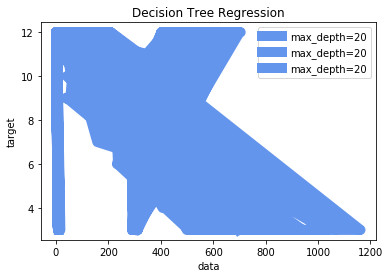

In [61]:
plt.figure()
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=20", linewidth=10)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Gradient Boosting Regressor

In [69]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [70]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
reg = ensemble.GradientBoostingRegressor(**params)

In [71]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [72]:
reg.fit(X_train, y_train)
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0008


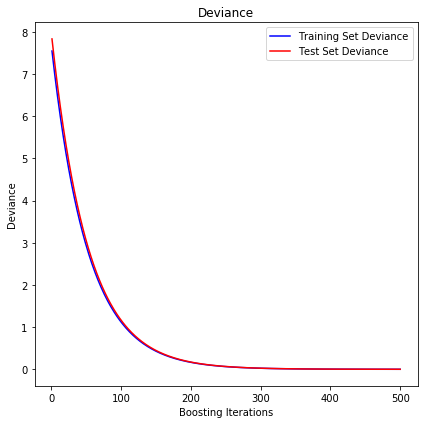

In [73]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()